**Batch Detect Puncta v1**

Aim: Detect puncta for a whole field of view!!

- added stdev and median calculation from region props (excludes 0=value pixels)

In [4]:
#Import modules
import numpy as np
import numpy.ma as MA
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import img_as_float
from skimage import morphology
import mahotas as mh
from skimage.feature import peak_local_max
from scipy.ndimage import maximum_filter

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

In [5]:
#[1] Get targeted filelist

path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [6]:
filelist[4]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_MMStack_Pos0.ome.tif'

In [7]:
#[2] Get Convex hull list
hull_list=glob.glob(path+str('/Output/ConvexHulls/*ConvHulls.npy')) ##Will need to get rid of the space in 'Convex Hulls'

In [8]:
hull_list[2]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments//Output/ConvexHulls\\Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_ConvHulls.npy'

In [9]:
#Load hulls
hulls = np.load(hull_list[2])

In [10]:
#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [11]:
##Extract channel information for a given file
[Hoechst_stack, GFP_stack] = load_ome(filelist[4])

In [12]:
z=4

(<matplotlib.axes._subplots.AxesSubplot at 0xe4f1d68>,
 <matplotlib.text.Text at 0xe3f53c8>)

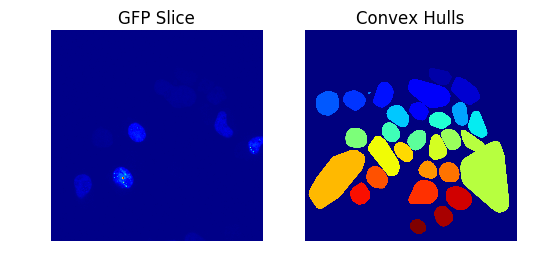

In [13]:
plt.subplot(1,2,1),plt.imshow(GFP_stack[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('GFP Slice')
plt.subplot(1,2,2),plt.imshow(hulls[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Convex Hulls')

#Note clear puncta in certain cells

In [22]:
##Measure properties (Super Fast)
hull_props=regionprops(label_image=hulls, intensity_image=GFP_stack)

In [23]:
##Save intensity images as you go (still Fast)
props=[]
indx=[]
im_g=[]

heading=["Center_x", "Center_y", "Center_z", "volume",  "integrated_GFP", "mean_GFP", "std_GFP", "median_GFP", "threshold_GFP"]

for h in hull_props:
    
    #Get bounding box
    bb=np.array(h.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox
    
    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    #Calculate stdev and median
    mask = h.intensity_image != 0
    
    std = np.std(h.intensity_image[mask])
    median = np.median(h.intensity_image[mask])
    
    #Calculate threshold
    thresh=median+(1.5*std)
    
    props.append([xcent,
                  ycent,
                  zcent,
                  h.area,
                  h.mean_intensity * h.area,
                  h.mean_intensity,
                  std,
                  median,
                  thresh])
    indx.append(h.label)
    
    #Store intensity image stack
    im_g.append(np.array(h.intensity_image))
    
Hull_Properties=pd.DataFrame(props, index=indx, columns=heading)

**Can we use a global local max filter to detect puncta within the convex hulls?**

bias by size and shape of footprint

single pixel ROIs

miss larger foci

(<matplotlib.axes._subplots.AxesSubplot at 0xd316080>,
 <matplotlib.text.Text at 0xc611f60>)

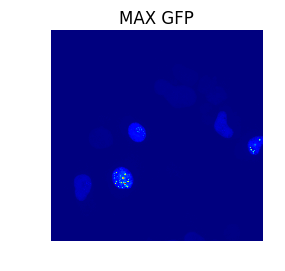

In [24]:
##Detect local maxima in GFP_stack
plt.subplot(1,2,1),plt.imshow(GFP_stack.max(axis=0))
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('MAX GFP')

In [25]:
#Maybe max.filter is faster (6.5s)
t0=time.time()
maxFilt = maximum_filter(GFP_stack, footprint=np.ones((3, 15, 15)))
scipy_local_maxima = GFP_stack==maxFilt
masked_scipy_local_maxima = scipy_local_maxima*hulls #label's puncta by hull
t1=time.time()
print(t1-t0)

6.27399992943


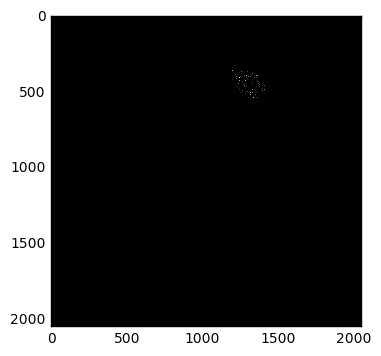

In [26]:
##All the maxima in the same hull are labeled the same
plt.imshow(masked_scipy_local_maxima.max(axis=0) == 1, cmap='gray')

In [27]:
#Count the puncta per label (reasonably quick)
def countPuncta(stack):

    puncta=[]
    n_puncta=[]

    #Iterate through hulls
    for l in range(1,stack.max()+1):
        print(l)

        pixels = stack == l

        #Count and label puncta
        punc, n_punc = mh.label(pixels)

        #Record number of puncta for hull properties
        n_puncta.append(n_punc)

        #Store puncta for puncta properties
        puncta.append(punc)
    
    return [puncta, n_puncta]

In [28]:
[puncta, n_puncta] = countPuncta(masked_scipy_local_maxima)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [29]:
##Calculate puncta density
Hull_Properties['local_maxima_GFP']=n_puncta
Hull_Properties['local_maxima_density_GFP']=Hull_Properties['local_maxima_GFP']/Hull_Properties['volume']

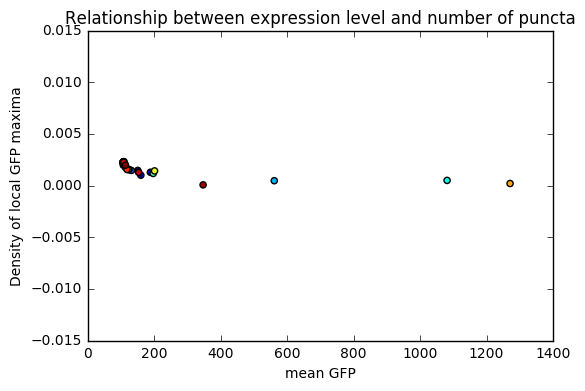

In [30]:
##Plot puncta density/ mean GFP
plt.scatter(Hull_Properties['mean_GFP'], Hull_Properties['local_maxima_density_GFP'], c=Hull_Properties.index)
plt.xlabel("mean GFP")
plt.ylabel("Density of local GFP maxima")
plt.title("Relationship between expression level and number of puncta")

In [31]:
#Evaluate region properties to discrimiate true puncta (So fast!)
 #These are just single pixels
    
union_maxima, n_maxima = mh.label(masked_scipy_local_maxima>0)    
    
##Measure properties (Super Fast)
pix_props=regionprops(label_image=union_maxima, intensity_image=GFP_stack)

In [32]:
pix=[]

pix_heading=["label","Center_x", "Center_y", "Center_z","intensity_GFP"]

for p in pix_props:
    
    #Get bounding box
    bb=np.array(p.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox
    
    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    #Calculate stdev and median
    mask = p.intensity_image != 0
    
    #std = np.std(p.intensity_image[mask])
    #median = np.median(p.intensity_image[mask])
    
    pix.append([p.label,
                xcent,
                  ycent,
                  zcent,
                  p.mean_intensity])
    
Pixel_Properties=pd.DataFrame(pix, columns=pix_heading)

(array([  4.80330000e+04,   3.27000000e+03,   5.00000000e+00,
          0.00000000e+00,   5.50000000e+01,   3.55000000e+02,
          2.64000000e+02,   1.47000000e+02,   2.50000000e+01,
          1.30000000e+01,   2.60000000e+01,   4.40000000e+01,
          9.20000000e+01,   7.70000000e+01,   4.50000000e+01,
          1.10000000e+01,   8.00000000e+00,   1.90000000e+01,
          1.90000000e+01,   2.20000000e+01,   1.10000000e+01,
          7.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

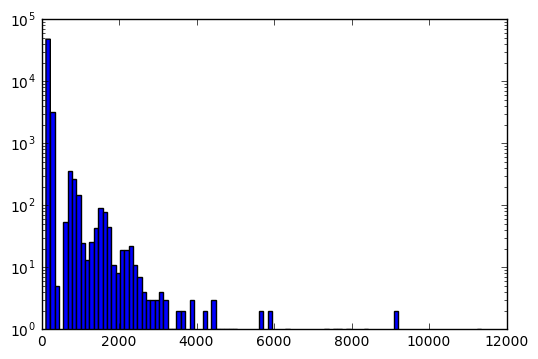

In [33]:
#Unexpectedly get phasing in histogram
plt.hist(Pixel_Properties['intensity_GFP'], bins=100, log=True)

In [34]:
##Try filtering union_maxima to exclude false positives
filtered_maxima, n_filtered = mh.label((union_maxima>0)*(GFP_stack>450)) 
n_filtered

1292L

(<matplotlib.axes._subplots.AxesSubplot at 0xd84d9080>,
 <matplotlib.text.Text at 0xd7f1b630>)

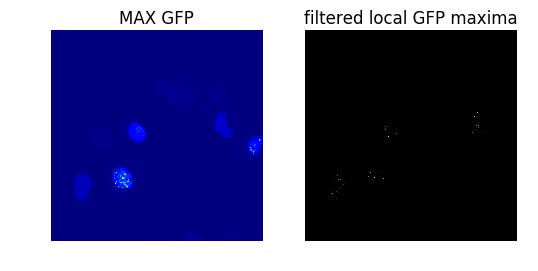

In [35]:
#Plot results
plt.subplot(1,2,1),plt.imshow(GFP_stack.max(axis=0))
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('MAX GFP')
plt.subplot(1,2,2),plt.imshow(filtered_maxima.max(axis=0)>0, cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('filtered local GFP maxima')

In [36]:
#Generate crop coordinates from the pandas data frame for a given index
def crop_crds(hull_index):

    #Use 'icol' to query pd.df 'Hull_Properties' with an integer
    Hull=Hull_Properties.iloc[hull_index]

    #Calculate cropped image coordinates
    z = int(Hull[2])
    y_min = int(Hull[1]-256)
    y_max = int(Hull[1]+256)
    x_min = int(Hull[0]-256)
    x_max = int(Hull[0]+256)
    
    return (z, y_min, y_max, x_min, x_max)

(<matplotlib.axes._subplots.AxesSubplot at 0xd7ec6e80>,
 <matplotlib.text.Text at 0xd8b2fb38>)

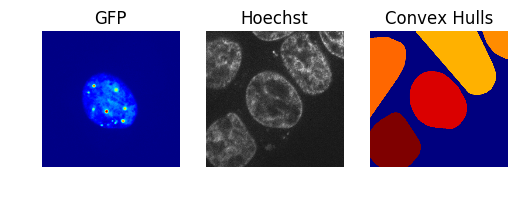

In [37]:
##Trim to a cell of interest
[z, y_min, y_max, x_min, x_max] = crop_crds(22) ##11 and 22 are good

##Display side by side
plt.subplot(1,3,1), plt.imshow(GFP_stack[z,y_min:y_max,x_min:x_max])
plt.subplot(1,3,1), plt.axis('off')
plt.subplot(1,3,1), plt.title('GFP')
plt.subplot(1,3,2), plt.imshow(Hoechst_stack[z,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,3,2), plt.axis('off')
plt.subplot(1,3,2), plt.title('Hoechst')
plt.subplot(1,3,3), plt.imshow(hulls[z,y_min:y_max,x_min:x_max])
plt.subplot(1,3,3), plt.axis('off')
plt.subplot(1,3,3), plt.title('Convex Hulls')

(<matplotlib.axes._subplots.AxesSubplot at 0xd8e8be10>,
 <matplotlib.text.Text at 0x16e677550>)

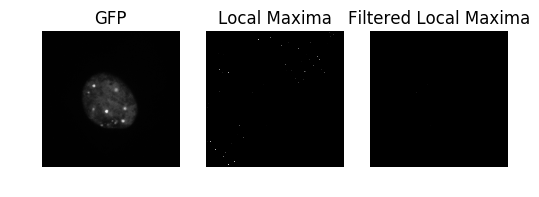

In [38]:
##Display side by side
plt.subplot(1,3,1), plt.imshow(GFP_stack[z,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,3,1), plt.axis('off')
plt.subplot(1,3,1), plt.title('GFP')
plt.subplot(1,3,2), plt.imshow(union_maxima[z,y_min:y_max,x_min:x_max]>0, cmap='gray')
plt.subplot(1,3,2), plt.axis('off')
plt.subplot(1,3,2), plt.title('Local Maxima')
plt.subplot(1,3,3), plt.imshow(filtered_maxima[z,y_min:y_max,x_min:x_max]>0, cmap='gray')
plt.subplot(1,3,3), plt.axis('off')
plt.subplot(1,3,3), plt.title('Filtered Local Maxima')

(<matplotlib.axes._subplots.AxesSubplot at 0xd8b237f0>,
 <matplotlib.text.Text at 0x16ebb2a58>)

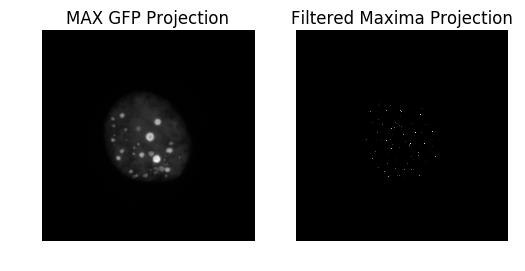

In [39]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[:,y_min:y_max,x_min:x_max].max(axis=0), cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('MAX GFP Projection')
plt.subplot(1,2,2), plt.imshow(filtered_maxima[:,y_min:y_max,x_min:x_max].max(axis=0)>0, cmap='gray')
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Filtered Maxima Projection')

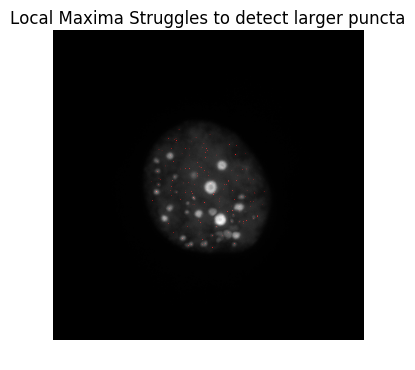

In [40]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[:,y_min:y_max,x_min:x_max].max(axis=0),filtered_maxima[:,y_min:y_max,x_min:x_max].max(axis=0)>0))
plt.axis('off')
plt.title('Local Maxima Struggles to detect larger puncta')
##Local Maxima Struggles to detect larger puncta

In [ ]:
# #Try with a larger footprint
# maxFilt50 = maximum_filter(GFP_stack, footprint=np.ones((3, 50, 50)))
# local_max50 = (GFP_stack==maxFilt50)*hulls #label's puncta by hull

In [ ]:
# #Count with the larger footprint
# [puncta50, n_puncta50] = countPuncta(local_max50)

In [ ]:
# union_max50, n_max50 = mh.label(local_max50>0)
# n_max50

In [ ]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[:,y_min:y_max,x_min:x_max].max(axis=0),union_max50[:,y_min:y_max,x_min:x_max].max(axis=0)>0))
plt.axis('off')
plt.title('Local Maxima Struggles to detect larger puncta')
##Increasing the foot print detects larger droplets but still doesn't detect the large donut structures

In [ ]:
#Try filtering for local maxima (Slow, 171s)
t0=time.time()
skimage_local_maxima = peak_local_max(GFP_stack,
                              indices=False,
                              footprint=np.ones((3, 15, 15)),
                              labels=hulls) #It does exlude maxima outside the convex hulls
t1=time.time()
print(t1-t0)

In [ ]:
centers = morphology.label(local_maxima)

In [ ]:
#Plot results
plt.subplot(1,2,1),plt.imshow(masked_scipy_local_maxima.max(axis=0))
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('MAX GFP')
plt.subplot(1,2,2),plt.imshow(local_maxima.max(axis=0), cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('local GFP maxima')

In [ ]:
##Check local max using overlay
plt.imshow(mh.overlay(GFP_stack[z,], morphology.binary_dilation(local_maxima[z], np.ones((9,9)))))

**Alternative is a cell by cell threshold**

bias by intensity

In [12]:
#[1] Threshold by Gloabl Mean
def meanThreshStack(stack):
    return stack > stack.mean()

In [11]:
import mahotas as mh  #used for filtering and labeling binary regions

#[2] 3D Gaussian Filter then mean
def gaussianThreshStack(stack, gaussian_filter_size=3):
    #By default gaussian_filter_size is 3
    smoothed_stack = mh.gaussian_filter(stack, gaussian_filter_size) 
    return smoothed_stack > smoothed_stack.mean()

In [12]:
GFP_mask2=gaussianThreshStack(GFP_stack)
plt.imshow(GFP_mask2[z])

NameError: name 'z' is not defined

In [ ]:
#5 Local Median Threshold (slow)
# from scipy.ndimage.filters import median_filter
# medianFilt = median_filter(GFP_stack, footprint=np.ones((3, 50, 50)))

In [15]:
from skimage.filters import threshold_otsu, threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35. I have set it to 9 for KDM5A puncta (even detects the hollow donuts)
#offset = Constant subtracted from mean. Default was 10. I have set it to -40 for GFP

#[3] Try local threshold
def localThreshStack(stack, block_size = 9, offset = -40):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            print(z)
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)

In [60]:
import numpy as np
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

#[4] Try local Otsu (Slow)
def localOtsuStack(stack, radius = 50):
#By default the radius is 50

    selem = disk(radius)

#Input must be a 2D array
    if len(stack.shape)>2:
        
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            local_otsu = rank.otsu(frame, selem)
            mask[z] = frame >= local_otsu
        return mask
    else:
        local_otsu = rank.otsu(stack, selem)         
        print 'Input is not a 3D stack'
        return stack >= local_otsu

(<matplotlib.axes._subplots.AxesSubplot at 0x1adb2ba8>,
 <matplotlib.text.Text at 0xc70b860>)

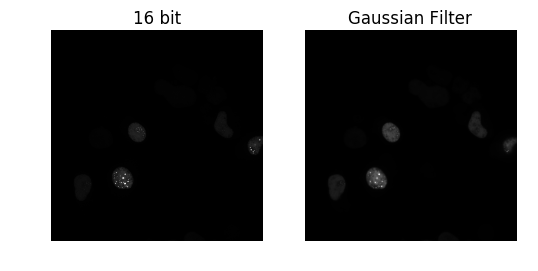

In [48]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack.max(axis=0), cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('16 bit')
plt.subplot(1,2,2), plt.imshow(smoothed_stack16[10], cmap='gray')
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Gaussian Filter')

In [76]:
#This is quick
GFP_mask3 = localThreshStack(GFP_stack, block_size=9, offset=-40)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


(<matplotlib.axes._subplots.AxesSubplot at 0x76704c50>,
 <matplotlib.text.Text at 0x768fbf98>)

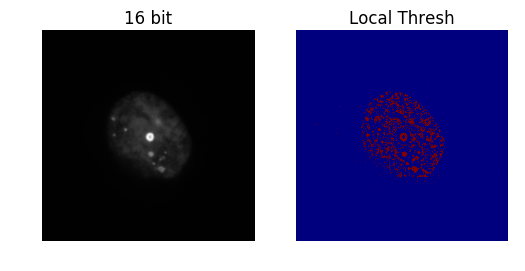

In [78]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack[4,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('16 bit')
plt.subplot(1,2,2), plt.imshow(GFP_mask3[4,y_min:y_max,x_min:x_max])
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Local Thresh')

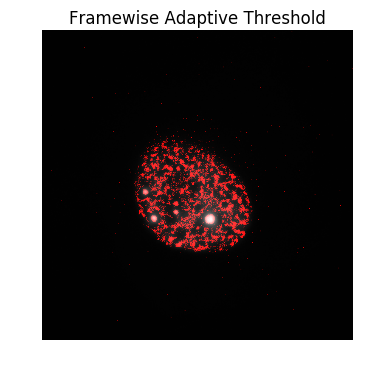

In [79]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[20,y_min:y_max,x_min:x_max],GFP_mask3[20,y_min:y_max,x_min:x_max]))
plt.axis('off')
plt.title('Framewise Adaptive Threshold')

In [80]:
##Intersect GFP mask with convex hulls to get GFP_mask5
GFP_mask5 = GFP_mask3 * (hulls>0)

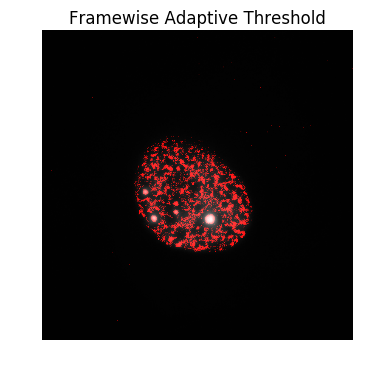

In [81]:
##Overlay
plt.imshow(mh.overlay(GFP_stack[20,y_min:y_max,x_min:x_max],GFP_mask5[20,y_min:y_max,x_min:x_max]))
plt.axis('off')
plt.title('Framewise Adaptive Threshold')

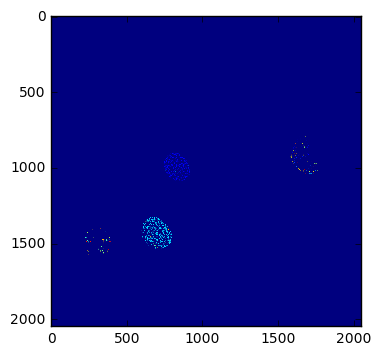

In [86]:
plt.imshow(real_blobs[5])

In [142]:
##Watershed blobs? Can I improve the resolution? At an earlier step?

##Calculate 3D distance transform
from scipy import ndimage

#This bit is simple
blob_dis = ndimage.distance_transform_edt(GFP_mask5)

#Limit to >1 to isolate blobs
iso_blobs = blob_dis>1

#Dilate blobs?

In [ ]:
blob_dis_test = ndimage.distance_transform_edt(GFP_mask5)

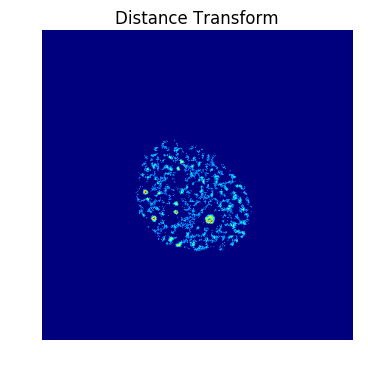

In [140]:
plt.imshow(blob_dis[20,y_min:y_max,x_min:x_max])
plt.axis('off')
plt.title('Distance Transform')

(<matplotlib.axes._subplots.AxesSubplot at 0x457829748>,
 <matplotlib.text.Text at 0x457b60550>)

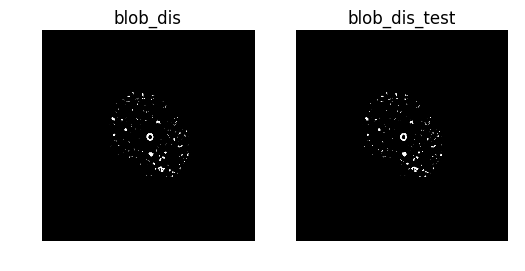

In [144]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(blob_dis[4,y_min:y_max,x_min:x_max]>1, cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('blob_dis')
plt.subplot(1,2,2), plt.imshow(blob_dis_test[4,y_min:y_max,x_min:x_max]>1, cmap='gray')
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('blob_dis_test')

In [145]:
##Label GFP regions (quick)
GFP_blobs, n_blobs = mh.label(iso_blobs)
n_blobs

8028L

In [146]:
#Filter by size
from mahotas.labeled import filter_labeled

filt_blobs, _ = mh.labeled.filter_labeled(GFP_blobs, min_size=27)

#Reset counts and count the labels, 
real_blobs, n_blobs_left = mh.labeled.relabel(filt_blobs)
print('After filtering and relabeling, there are {} blobs left.'.format(n_blobs_left))

After filtering and relabeling, there are 282 blobs left.


(<matplotlib.axes._subplots.AxesSubplot at 0x477ca0c88>,
 <matplotlib.text.Text at 0x478179be0>)

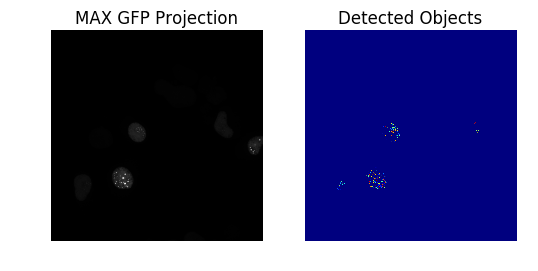

In [152]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_stack.max(axis=0), cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('MAX GFP Projection')
plt.subplot(1,2,2), plt.imshow(real_blobs.max(axis=0))
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Detected Objects')

(<matplotlib.axes._subplots.AxesSubplot at 0x478160128>,
 <matplotlib.text.Text at 0x4856dde80>)

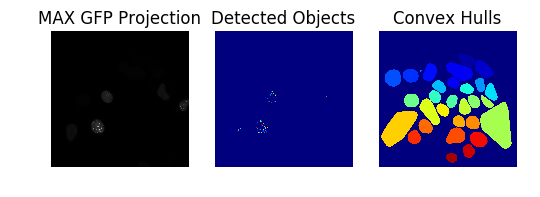

In [153]:
##Display side by side
plt.subplot(1,3,1), plt.imshow(GFP_stack.max(axis=0), cmap='gray')
plt.subplot(1,3,1), plt.axis('off')
plt.subplot(1,3,1), plt.title('MAX GFP Projection')
plt.subplot(1,3,2), plt.imshow(real_blobs.max(axis=0))
plt.subplot(1,3,2), plt.axis('off')
plt.subplot(1,3,2), plt.title('Detected Objects')
plt.subplot(1,3,3), plt.imshow(hulls[z])
plt.subplot(1,3,3), plt.axis('off')
plt.subplot(1,3,3), plt.title('Convex Hulls')

In [122]:
#This bit is the challenge   
dis_maxi = peak_local_max(blob_dis,
                          indices=False,
                          footprint=np.ones((1, 30, 30)),
                          threshold_abs=2)

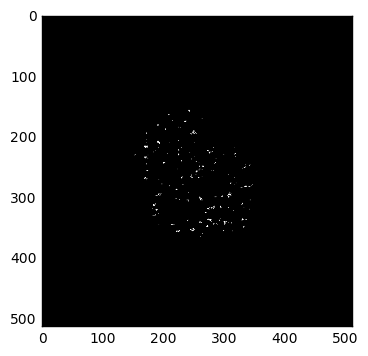

In [123]:
plt.imshow(dis_maxi[:,y_min:y_max,x_min:x_max].max(axis=0), cmap='gray')

In [124]:
#Find the centers
markers = morphology.label(dis_maxi)

In [125]:
#Watershed image (quite quick)
blobs_ws = morphology.watershed(-blob_dis, markers, mask=GFP_mask5)

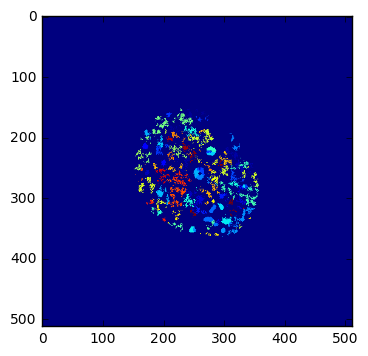

In [126]:
plt.imshow(blobs_ws[7,y_min:y_max,x_min:x_max])
#plt.imshow(blobs_ws[11])

In [132]:
#Try reconstruction from local maxima
from skimage.morphology import disk

recon = morphology.reconstruction(filtered_maxima>0, GFP_mask5, 'dilation')

(<matplotlib.axes._subplots.AxesSubplot at 0x4452cde80>,
 <matplotlib.text.Text at 0x4454c3ac8>)

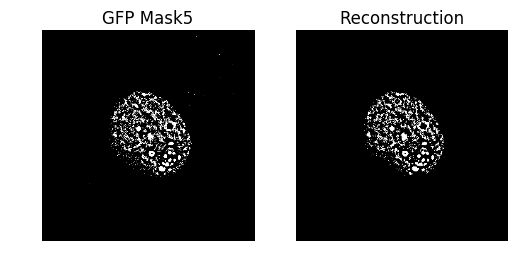

In [137]:
##Display side by side
plt.subplot(1,2,1), plt.imshow(GFP_mask5[0,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('GFP Mask5')
plt.subplot(1,2,2), plt.imshow(recon[0,y_min:y_max,x_min:x_max], cmap='gray')
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Reconstruction')

In [ ]:
##Do I need to iterate through the stack
#3D watershed
def watershed3D(binary_stack):

    ws3D = np.zeros_like(binary_stack)

    for z, frame in enumerate(binary_stack):
        print(z)
        ws3D[z] = watershed(-distance[z], centers[z], mask=binary_stack[z])
    return ws3D

In [ ]:
thresh_p=Hull_Properties.loc[1,'threshold_GFP']
thresh_p

In [ ]:
##Cell by cell - Detect puncta in intensity image stack
##Define a function to find puncta in a given cell
def puncFinder(cell):

    #Get intensity image
    im_c=im_g[cell-1]  #subtract 1 because Hull_Properties is a pandas df, but im_g is not 

    #Get the relevant threshold
    thresh_p=Hull_Properties.loc[cell,'threshold_GFP'] 
    
    ##Enforce connectivity
    pixels=im_c>thresh_g
    con_regions, n_con_regions=mh.label(pixels)
    #print('There are {} regions above the threshold.'.format(n_con_regions))

    puncta, n_puncta=mh.labeled.filter_labeled(con_regions, remove_bordering=True, min_size=4, max_size=int(vol/2))
    
    relabeled, n_left=mh.labeled.relabel(puncta)
    #print('After filtering, there are {} puncta above the threshold.'.format(n_puncta))
    
    return relabeled

In [ ]:
img

In [ ]:
Hull_Properties.iloc[11]

In [ ]:
##Add a new column to pd.df
Background_GFP=150  #Need an unbiased way to calculate Background GFP signal

Hull_Properties["Transfected"] = Hull_Properties["mean_GFP"]>Background_GFP 

In [ ]:
#Plot the thresholded image
plt.subplot(1,2,1), plt.imshow(im_g.max(axis=0))
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('Thresholded Image')

#Plot the potential puncta
plt.subplot(1,2,2), plt.imshow(puncta.max(axis=0))
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Puncta')

In [ ]:
##Find a textbook case
plt.imshow(hull_props[11].intensity_image.max(axis=0))
plt.axis('off')
#plt.imshow(hull_props[6].intensity_image[12])

In [ ]:
##Define a function to find puncta in a given cell
def puncFinder(cell):

    #Get intensity image
    im_g=np.array(hull_props[cell-1].intensity_image)  #subtract 1 because Hull_Properties is a pandas df, but hull_props is not 

    mean_g = Hull_Properties.loc[cell, 'mean_GFP']

    std_g = Hull_Properties.loc[cell, 'std_GFP']

    median_g = Hull_Properties.loc[cell, 'median_GFP']

    vol = Hull_Properties.loc[cell, 'volume']

    thresh_g=median_g+(2*std_g)
    
    ##Enforce connectivity
    pixels=im_g>thresh_g
    con_regions, n_con_regions=mh.label(pixels)
    #print('There are {} regions above the threshold.'.format(n_con_regions))

    puncta, n_puncta=mh.labeled.filter_labeled(con_regions, remove_bordering=True, min_size=4, max_size=int(vol/2))
    
    relabeled, n_left=mh.labeled.relabel(puncta)
    print('After filtering, there are {} puncta above the threshold.'.format(n_puncta))
    
    return relabeled

In [ ]:
cell12_puncta=puncFinder(12)

In [ ]:
#Plot the thresholded image
plt.subplot(1,2,1), plt.imshow(hull_props[11].intensity_image.max(axis=0))
plt.subplot(1,2,1), plt.axis('off')
plt.subplot(1,2,1), plt.title('Thresholded Image')

#Plot the potential puncta
plt.subplot(1,2,2), plt.imshow(cell12_puncta.max(axis=0))
plt.subplot(1,2,2), plt.axis('off')
plt.subplot(1,2,2), plt.title('Cell12 Puncta')

### Having Detected Puncta for Each Cell

Measure some properties

In [ ]:
#Get puncta properties
props=[]
indx=[]

punc_props=regionprops(label_image=puncta, intensity_image=im_g)

heading=["Center_x", "Center_y", "Center_z", "volume", "mean_GFP", "integrated_GFP"]

for p in punc_props:
    
    #Get bounding box
    bb=np.array(p.bbox)
    #zmin, ymin, xmin, zmax, ymax, xmax  = h.bbox
    
    #Calculate Center
    zcent=int(round((bb[0]+bb[3])/2))
    ycent=int(round((bb[1]+bb[4])/2))
    xcent=int(round((bb[2]+bb[5])/2))
    
    props.append([xcent,
                  ycent,
                  zcent,
                  p.area,
                  p.mean_intensity,
                  p.mean_intensity * p.area])
    indx.append(p.label)
Puncta_Properties=pd.DataFrame(props, index=indx, columns=heading)

In [ ]:
#Plot mean_GFP against size
plt.scatter(Puncta_Properties['volume'], Puncta_Properties['mean_GFP'], c=Puncta_Properties.index)
plt.xlabel("Volume (pixels)")
plt.ylabel("mean GFP")
plt.title("Bright puncta")

In [ ]:
##Compare clear puncta vs noise


In [46]:
smoothed_stack16=np.ndarray.round(smoothed_stack)

In [9]:
##Converting GFP_stack to 8bit is no good
# from skimage import img_as_ubyte 
# GFP_8bit = img_as_ubyte(GFP_stack)

C:\Users\David Brown\Anaconda2\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from uint16 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
